In [1]:
import pandas as pd
from pycirclize import Circos
from matplotlib.patches import Patch
import numpy as np

In [2]:
# Color map

color_map = {
    "ORF": "#009e73cc",
    "Target2": "#0072b2cc",
    "Target1": "#f0e442cc",
    "Untreated": "#cc79a7cc",
}

Polybrene_map = {
    "Present": "#000000cc",
    "Absent": "#ffffffcc",
}

Read experiment metadata file 

In [3]:
experiment_metadata_df = (
    pd.read_csv("../00.download-and-process-annotations/input/experiment-metadata.tsv", sep="\t")
    .query('Batch!="Batch12"')
    .query('Anomaly!="other"')
    .reset_index(drop=True)
)

experiment_metadata_df.head()

,Batch,Batch_name,Plate_Map_Name,Assay_Plate_Barcode,Type,Anomaly,Density,Polybrene
0,Batch1,2021_04_26_Batch1,JUMP-Target-2_compound_platemap,BR00121438,Target2,dye,100,Absent
1,Batch1,2021_04_26_Batch1,JUMP-Target-2_compound_platemap,BR00121439,Target2,dye,100,Present
2,Batch1,2021_04_26_Batch1,OAA01.02.03.04.A,BR00117035,ORF,none,100,Present
3,Batch1,2021_04_26_Batch1,OAA01.02.03.04.A,BR00117036,ORF,none,100,Present
4,Batch1,2021_04_26_Batch1,OAA01.02.03.04.A,BR00121558,ORF,dye,100,Present


In [4]:
# Add leading zeros to batch

experiment_metadata_df["Batch"] = experiment_metadata_df["Batch"].apply(
    lambda x: f"{x[0:5]}{int(x[5:]):02}"
)

experiment_metadata_df.head()

,Batch,Batch_name,Plate_Map_Name,Assay_Plate_Barcode,Type,Anomaly,Density,Polybrene
0,Batch01,2021_04_26_Batch1,JUMP-Target-2_compound_platemap,BR00121438,Target2,dye,100,Absent
1,Batch01,2021_04_26_Batch1,JUMP-Target-2_compound_platemap,BR00121439,Target2,dye,100,Present
2,Batch01,2021_04_26_Batch1,OAA01.02.03.04.A,BR00117035,ORF,none,100,Present
3,Batch01,2021_04_26_Batch1,OAA01.02.03.04.A,BR00117036,ORF,none,100,Present
4,Batch01,2021_04_26_Batch1,OAA01.02.03.04.A,BR00121558,ORF,dye,100,Present


In [5]:
# Sorting the dataframe by Batch and Assay_Plate_Barcode

experiment_metadata_df = experiment_metadata_df.sort_values(
    by=["Batch", "Assay_Plate_Barcode"],
).reset_index(drop=True)

In [6]:
# Number of plates per platemap per perturbation type per batch

n_plates_platemap_perturbation_batch = (
    experiment_metadata_df.groupby(["Batch", "Type", "Plate_Map_Name"])
    .agg({"Assay_Plate_Barcode": "count"})
    .reset_index()
)

n_plates_platemap_perturbation_batch.head()

,Batch,Type,Plate_Map_Name,Assay_Plate_Barcode
0,Batch01,ORF,OAA01.02.03.04.A,5
1,Batch01,ORF,OAA05.06.07.08.A,5
2,Batch01,ORF,OAA09.10.11.12.A,5
3,Batch01,ORF,OAB84.85.86.87.A,5
4,Batch01,Target2,JUMP-Target-2_compound_platemap,2


In [7]:
# Number of plates per perturbation type per batch

n_plates_perturbation_batch = (
    n_plates_platemap_perturbation_batch.groupby(["Batch", "Type"])
    .agg({"Assay_Plate_Barcode": "sum"})
    .reset_index()
)

n_plates_perturbation_batch.head()

,Batch,Type,Assay_Plate_Barcode
0,Batch01,ORF,20
1,Batch01,Target2,2
2,Batch01,Untreated,2
3,Batch02,ORF,20
4,Batch02,Target2,1


In [8]:
# Number of plates per batch

n_plates_batch = (
    n_plates_perturbation_batch.groupby("Batch")
    .agg({"Assay_Plate_Barcode": "sum"})
    .reset_index()
)

n_plates_batch.head()

,Batch,Assay_Plate_Barcode
0,Batch01,24
1,Batch02,22
2,Batch03,22
3,Batch04,22
4,Batch05,22


In [9]:
# Density values per batch

density_batch = (
    experiment_metadata_df.groupby("Batch").Density.apply(list)
    .reset_index()
)

density_batch.head()

,Batch,Density
0,Batch01,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ..."
1,Batch02,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ..."
2,Batch03,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ..."
3,Batch04,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ..."
4,Batch05,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ..."


In [10]:
# Polybrene status per batch

polybrene_batch = (
    experiment_metadata_df.groupby(["Batch","Type"]).Polybrene.apply(list)
    .reset_index()
)

polybrene_batch.head()

,Batch,Type,Polybrene
0,Batch01,ORF,"[Present, Present, Present, Present, Present, ..."
1,Batch01,Target2,"[Absent, Present]"
2,Batch01,Untreated,"[Present, Absent]"
3,Batch02,ORF,"[Present, Present, Present, Present, Present, ..."
4,Batch02,Target2,[Absent]


In [11]:
# Create pycirclize sectors

sectors = dict(zip(n_plates_batch.Batch, n_plates_batch.Assay_Plate_Barcode))

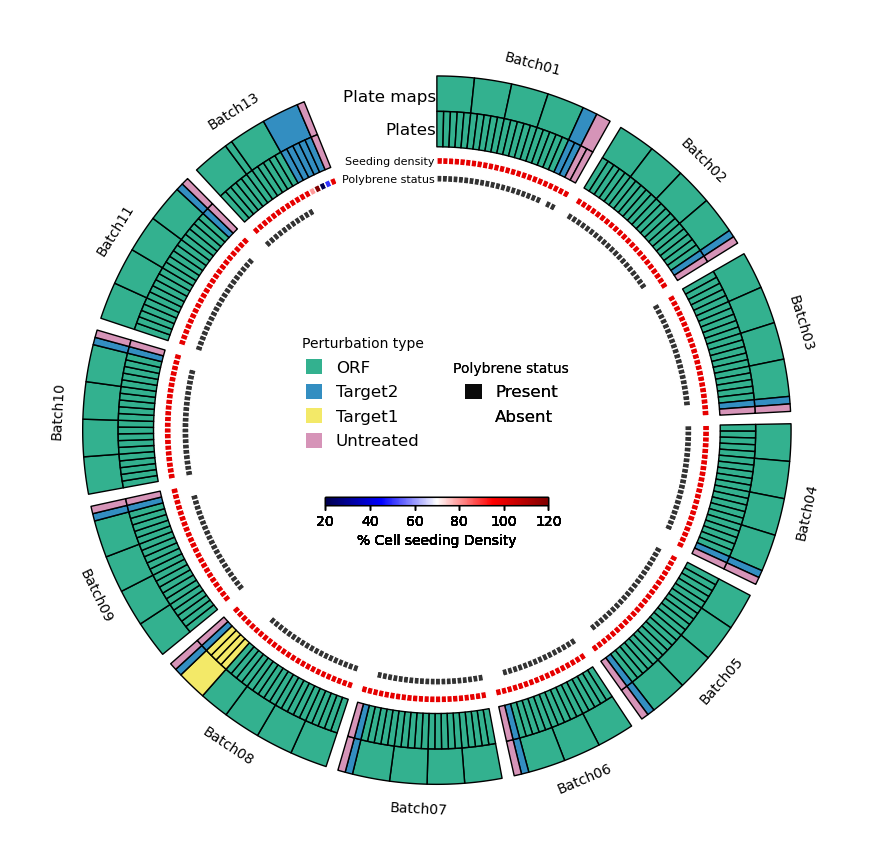

In [12]:
# Draw circos plot

circos = Circos(sectors, space=2, start=0, end=340)

for sector in circos.sectors:
    sector.text(sector.name)

    # Draw plate map level

    platemap_counter = 0

    for platemap in n_plates_platemap_perturbation_batch.query(
        "Batch==@sector.name"
    ).Plate_Map_Name.unique():
        n_plates_platemap = n_plates_platemap_perturbation_batch.query(
            "Batch==@sector.name & Plate_Map_Name==@platemap"
        ).Assay_Plate_Barcode.values[0]
        pert_type = n_plates_platemap_perturbation_batch.query(
            "Batch==@sector.name & Plate_Map_Name==@platemap"
        ).Type.values[0]

        sector.rect(
            start=platemap_counter,
            end=platemap_counter + n_plates_platemap,
            r_lim=(90, 100),
            fc=color_map[pert_type],
            ec="black",
            lw=1,
        )

        platemap_counter += n_plates_platemap

    # Draw plate level

    plate_counter = 0
    for pert_type in n_plates_perturbation_batch.query(
        "Batch==@sector.name"
    ).Type.unique():
        n_plates = n_plates_perturbation_batch.query(
            "Batch==@sector.name & Type==@pert_type"
        ).Assay_Plate_Barcode.values[0]

        for i in range(plate_counter, plate_counter + n_plates):
            sector.rect(
                start=i,
                end=i + 1,
                r_lim=(80, 90),
                fc=color_map[pert_type],
                ec="black",
                lw=1,
            )
        plate_counter += n_plates

    # Add Seeding density level
    density_values = np.array(
        [density_batch.query("Batch==@sector.name").Density.values[0]]
    )
    track3 = sector.add_track((75, 77))
    track3.heatmap(
        density_values,
        vmin=20,
        vmax=120,
        cmap="seismic",
        rect_kws=dict(ec="white", lw=1),
    )
    circos.colorbar(
        bounds=(0.35, 0.4, 0.3, 0.01),
        vmin=20,
        vmax=120,
        cmap="seismic",
        orientation="horizontal",
        colorbar_kws=dict(label="% Cell seeding Density"),
    )

    # Add Polybrene level

    polybrene_plate_counter = 0

    for pert_type in polybrene_batch.query("Batch==@sector.name").Type.unique():
        polybrene_status = polybrene_batch.query(
            "Batch==@sector.name & Type==@pert_type"
        ).Polybrene.values[0]

        polybrene_status_counter = 0

        for i in range(
            polybrene_plate_counter, polybrene_plate_counter + len(polybrene_status)
        ):
            sector.rect(
                start=i,
                end=i + 1,
                r_lim=(70, 72),
                fc=Polybrene_map[polybrene_status[polybrene_status_counter]],
                ec="white",
                lw=1,
            )
            polybrene_status_counter += 1
        polybrene_plate_counter += len(polybrene_status)

# Add text
circos.text("Plate maps", r=95, deg=352, size=12, color="black")
circos.text("Plates", r=85, deg=355, size=12, color="black")
circos.text("Seeding density", r=77, deg=350, size=8, color="black")
circos.text("Polybrene status", r=72, deg=349, size=8, color="black")

fig = circos.plotfig()

pert_type_handles = []

for pert_type in color_map:
    pert_type_handles.append(Patch(color=color_map[pert_type], label=pert_type))

pert_type_legend = circos.ax.legend(
    handles=pert_type_handles,
    bbox_to_anchor=(0.4, 0.55),
    loc="center",
    fontsize=12,
    title="Perturbation type",
)

circos.ax.add_artist(pert_type_legend)

polybrene_handles = []

for status in Polybrene_map:
    polybrene_handles.append(Patch(color=Polybrene_map[status], label=status))

polybrene_legend = circos.ax.legend(
    handles=polybrene_handles,
    bbox_to_anchor=(0.6, 0.55),
    loc="center",
    fontsize=12,
    title="Polybrene status",
)

circos.ax.add_artist(polybrene_legend)

fig.savefig("figures/orf_experiment_circos.png", dpi=300, transparent=True)
fig.savefig("figures/orf_experiment_circos.svg", dpi=300, transparent=True)